# Covariance Estimation

In [8]:
# used during development to releoad modules every time there is a change
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

import statsmodels.api as sm
from course_1.risk_kit import Metrics
import nb.edhec_risk_kit_205 as erk
from backtesting import Backtester, EquallyWeighted, CapWeighted,\
GlobalMiminumVariance

import ipywidgets as widgets
import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.options.display.float_format = '{:.6f}'.format

m= Metrics()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
inds = ['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other']
#inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_returns(weighting="ew", n_inds=49)["1974":]
ind_mcap = erk.get_ind_market_caps(49, weights=True)["1974":]

<Axes: title={'center': 'Industry Portfolios - CW vs EW'}>

,Ann. Return,Ann. Volatility,Skewness,Kurtosis,Corn-Fisher VaR (5%),Hist. CVar (5%),Sharpe Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.527384,-0.598060
CW,0.131522,0.187236,-0.544912,5.820495,0.081975,0.120151,0.527515,-0.587850


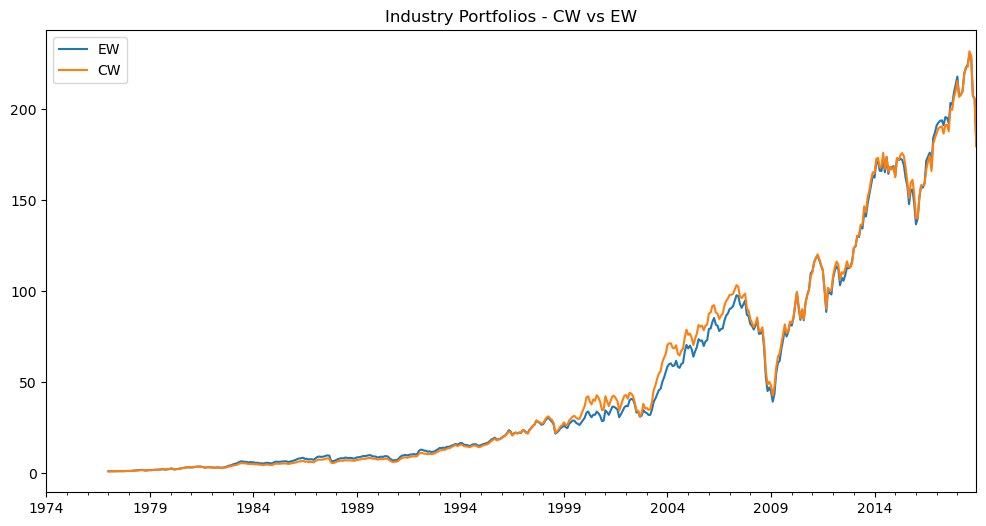

In [3]:
# let's add the Global Minimum Variance (GMV) portfolio.
# It requires an estimate of the covariance matrix
ewr = Backtester(EquallyWeighted(), estimation_window=36).run(ind_rets)
cwr = Backtester(CapWeighted(cap_weights=ind_mcap), estimation_window=36).run(ind_rets)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios - CW vs EW");
m.summary_stats(btr.dropna())

<Axes: title={'center': 'Industry Portfolios'}>

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.527384,-0.598060
CW,0.131522,0.187236,-0.544912,5.820495,0.081975,0.120151,0.527515,-0.587850
GMV-Sample,0.153094,0.116303,-0.811385,6.408513,0.047674,0.072557,1.030064,-0.463912


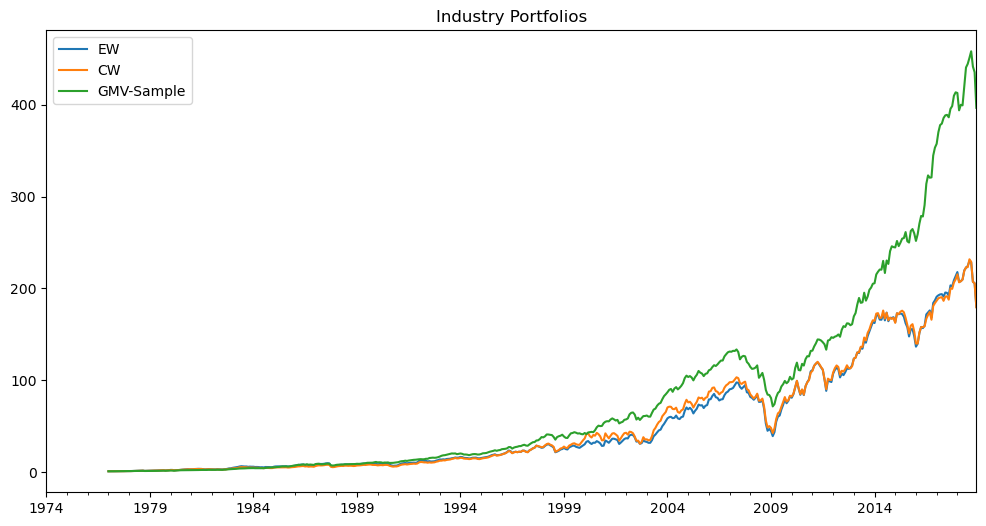

In [4]:
mv_s_r =  Backtester(GlobalMiminumVariance(cov_estimator="sample_cov"), estimation_window=36).run(ind_rets)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

Now, let's try a new estimator - Constant Correlation. The idea is simple, take the sample correlation matrix, compute the average correlation and then reconstruct the covariance matrix. The relation between correlations $\rho$ and covariance $\sigma$ is given by:

$$ \rho_{ij} = \frac{ \sigma_{ij} } { \sqrt{ \sigma_{ii}  \sigma_{jj} } } $$

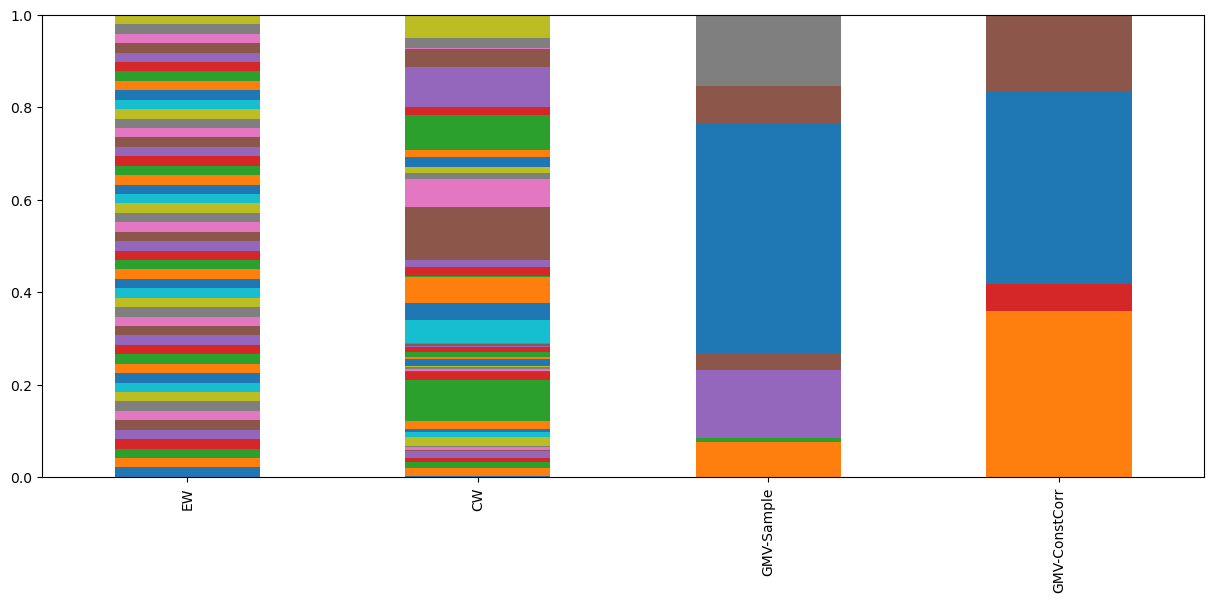

In [12]:
wts = pd.DataFrame({
    "EW": EquallyWeighted().compute_weights(ind_rets["2016":]),
    "CW": CapWeighted(cap_weights=ind_mcap).compute_weights(ind_rets["2016":]),
    "GMV-Sample": GlobalMiminumVariance(cov_estimator="sample_cov").compute_weights(ind_rets["2016":]),
    "GMV-ConstCorr": GlobalMiminumVariance(cov_estimator="const_corr").compute_weights(ind_rets["2016":])
})
wts.T.plot.bar(stacked=True, figsize=(15,6), legend=False);

<Axes: title={'center': 'Industry Portfolios'}>

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.527384,-0.598060
CW,0.131522,0.187236,-0.544912,5.820495,0.081975,0.120151,0.527515,-0.587850
GMV-Sample,0.153094,0.116303,-0.811385,6.408513,0.047674,0.072557,1.030064,-0.463912
GMV-CC,0.132375,0.115347,-0.890920,6.072388,0.049608,0.075267,0.863745,-0.524097


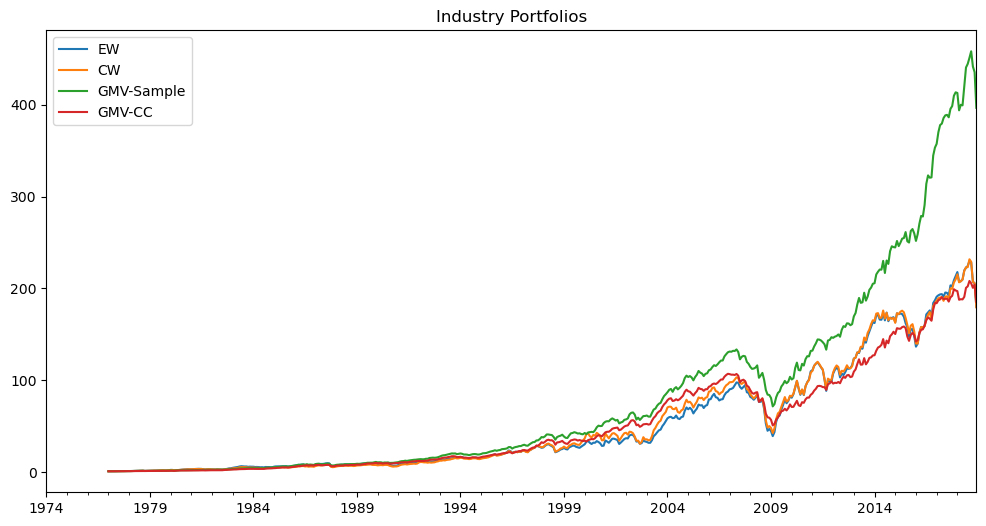

In [13]:
mv_cc_r =  Backtester(GlobalMiminumVariance(cov_estimator="const_corr"), estimation_window=36).run(ind_rets)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

 When you're looking at individual stocks, this very little signal a lot of noise. In other words, there's a lot of idiosyncratic variants or idiosyncratic volatility in the stock price. When you start putting portfolios of them together, such as we're using here, you will start to see that idiosyncratic portions all wash out, all those noise components wash out and you'll start to see more cohesive behavior. 

### Statistical Shrinkage

We can mix the model and sample estimates by choosing a shrinkage parameter. You can either let the numbers dictate an optimal shrinkage value for $\delta$ although in practice many practiotioners choose $0.5$. Let's implement a simple shrinkage based covariance estimator that shrinks towards the Constant Correlation estimate.

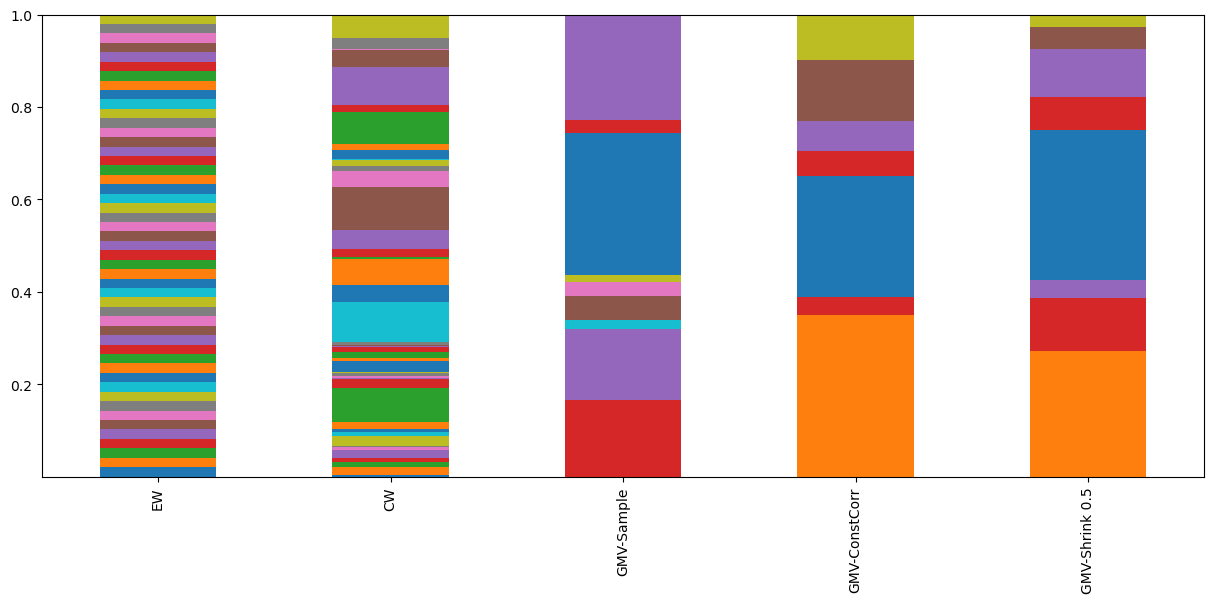

In [96]:
delta = 0.5 # param. for shrinkage cov. matrix

wts = pd.DataFrame({
    "EW": EquallyWeighted().compute_weights(ind_rets["2013":]),
    "CW": CapWeighted(cap_weights=ind_mcap).compute_weights(ind_rets["2013":]),
    "GMV-Sample": GlobalMiminumVariance(cov_estimator="sample_cov").compute_weights(ind_rets["2013":]),
    "GMV-ConstCorr": GlobalMiminumVariance(cov_estimator="const_corr").compute_weights(ind_rets["2013":]),
    f"GMV-Shrink {delta}": GlobalMiminumVariance(cov_estimator="shrink_cov", delta=delta).compute_weights(ind_rets["2013":])
})
wts.T.plot.bar(stacked=True, figsize=(15,6), legend=False);

<Axes: title={'center': 'Industry Portfolios'}>

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.527384,-0.598060
CW,0.131522,0.187236,-0.544912,5.820495,0.081975,0.120151,0.527515,-0.587850
GMV-Sample,0.153094,0.116303,-0.811385,6.408513,0.047674,0.072557,1.030064,-0.463912
GMV-CC,0.138502,0.114873,-0.886400,6.305892,0.048716,0.074239,0.919236,-0.518447


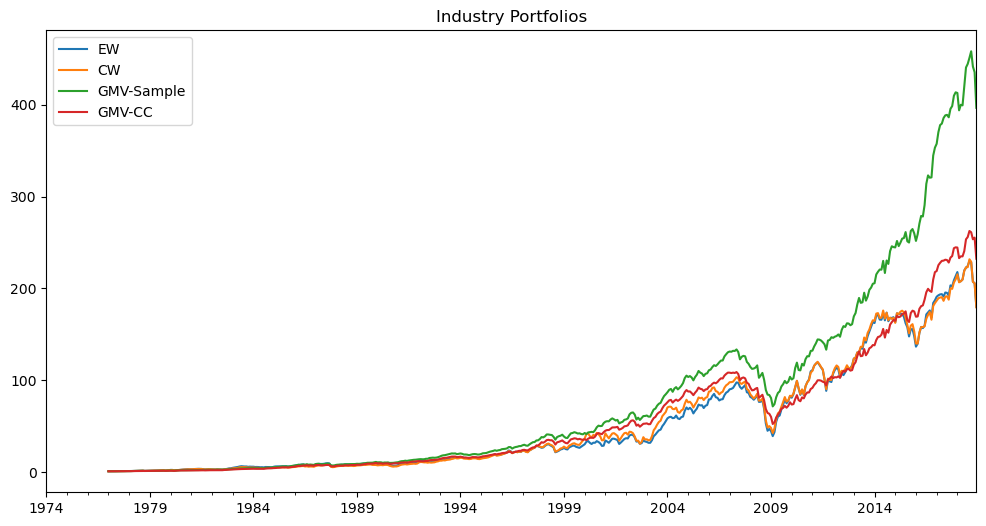

In [97]:
mv_cc_r =  Backtester(GlobalMiminumVariance(cov_estimator="shrink_cov" , delta=0.5), estimation_window=36).run(ind_rets)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())